In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('../data/sales.csv')

In [3]:
df.dropna(subset=['price'], inplace=True)

In [4]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [5]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year

In [6]:
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# 1. Timestamp Features

<font color='red'>Assignment:</font> Build a class to transform **purchase_date** into numerical features include **year**, **month**, **weekday**, and **day**.

In [7]:
class Date_Transformer(object):
    
    def fit(self, X, y=None):
        self.datetime = pd.to_datetime(X)
    
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['year'] = pd.to_datetime(X).dt.year
        df['month'] = pd.to_datetime(X).dt.month
        df['weekday'] = pd.to_datetime(X).dt.weekday
        df['day'] = pd.to_datetime(X).dt.day
        return df
            
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X) 

<font color='red'>Assignment:</font> Wrap up the above transformer and linear regression as a pipeline to predict **price** using these features.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

steps = [('dtf', Date_Transformer()),
         ('lr', LinearRegression())]

model = Pipeline(steps)

In [9]:
y_train = train_raw['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))
y_test = test_raw['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))

In [10]:
model = model.fit(train_raw["purchase_date"], y_train)

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_train_pred = model.predict(train_raw["purchase_date"])
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = model.predict(test_raw["purchase_date"])
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.34e+05
train MSE: 4.10e+10
train R2: 0.039
train MAE: 1.90e+05
train MSE: 8.67e+10
train R2: -0.005


# 2. ARIMA

<font color='red'>Assignment:</font> Creat a new DataFrame named **new_df** containing numerical **price** and **year** of the purchase. 

In [16]:
new_df = pd.DataFrame()
new_df['price'] = df['price'].map(lambda x: x if type(x) == float else float(x.strip('$').replace(',', '')))
new_df['year'] = pd.to_datetime(df['purchase_date']).dt.year
new_df.head()

,price,year
0,300492.0,2008
1,430570.0,1997
2,213070.0,2001
3,229174.0,2016
4,122659.0,2000


<font color='red'>Assignment:</font> Get the averaged price for each year. Hint: use **groupby**. 

In [19]:
year_avg = pd.DataFrame({'year': new_df.year, 'price': new_df.price}).groupby('year').mean()

In [20]:
year_avg.head()

,price
year,
1996,92974.589744
1997,119849.041667
1998,143776.348993
1999,142815.307143
2000,151443.718310


<font color='red'>Assignment:</font> Build a LinearRegression model to predict the yearly averaged price using averaged prices in the past three years. For example, to predict the averaged price in 2015 with the averaged price in 2014, 2013, and 2012. (Hint: use **shift** and you can discard the rows containing nan values.) Get the training and testing scores.

In [21]:
year_avg['shift1'] = year_avg.price.shift(1)
year_avg['shift2'] = year_avg.price.shift(2)
year_avg['shift3'] = year_avg.price.shift(3)
year_avg.head()

,price,shift1,shift2,shift3
year,,,,
1996,92974.589744,NaN,NaN,NaN
1997,119849.041667,92974.589744,NaN,NaN
1998,143776.348993,119849.041667,92974.589744,NaN
1999,142815.307143,143776.348993,119849.041667,92974.589744
2000,151443.718310,142815.307143,143776.348993,119849.041667


In [53]:
year_avg = year_avg.dropna()
year_avg_train = year_avg.iloc[:-3]
year_avg_test = year_avg.iloc[-3:]

In [54]:
lr = LinearRegression()
lr = lr.fit(year_avg_train[['shift1', 'shift2', 'shift3']], year_avg_train['price'])

In [55]:
y_train_pred = lr.predict(year_avg_train[['shift1', 'shift2', 'shift3']])
y_train = year_avg_train['price']
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

y_test_pred = lr.predict(year_avg_test[['shift1', 'shift2', 'shift3']])
y_test = year_avg_test['price']
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

train MAE: 1.18e+04
train MSE: 1.83e+08
train R2: 0.769
train MAE: 3.21e+04
train MSE: 1.04e+09
train R2: -16.182


<font color='red'>Assignment:</font> Plot the prediction and ground truth of yearly averaged **price** against time. 

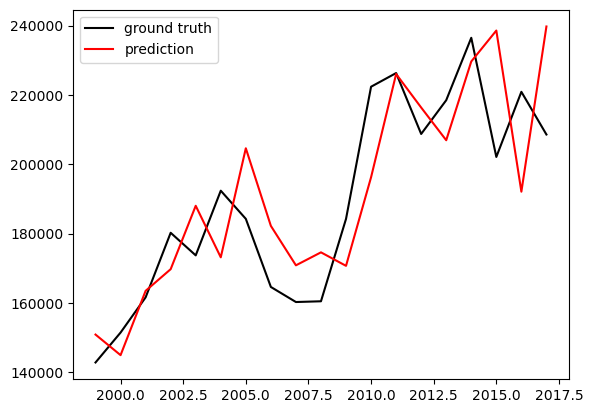

In [60]:
import matplotlib.pylab as plt
%matplotlib inline

plt.plot(year_avg.index, pd.concat([y_train, y_test]),'k')
plt.plot(year_avg.index, pd.concat([pd.Series(y_train_pred), pd.Series(y_test_pred)]),'r')
plt.legend(['ground truth', 'prediction'])

<font color='red'>Question:</font> What is ARIMA?

In [ ]:
# ARIMA is an acronym for 'autoregressive intergrated moving average'. It is a model used in time series data to predict the
# future data of the seires.

# 3. Use time features and historical price to predict price (Example)

In [61]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [62]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year

In [63]:
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

In [64]:
class Historical_Transformer(object):
    
    def fit(self, X, y):
        self.datetime = pd.to_datetime(X)
        self.year_avg = pd.DataFrame({'year': self.datetime.dt.year, 
                                      'price': y}).groupby('year').mean()
        test = pd.DataFrame({'price': [0, 0, 0]}, index=[2015, 2016, 2017])
        self.year_avg = self.year_avg.append(test)
        self.year_avg['shift_3'] = self.year_avg.price.shift(3)
        self.year_avg['shift_4'] = self.year_avg.price.shift(4)
        self.year_avg['shift_5'] = self.year_avg.price.shift(5)
        self.year_avg.drop('price', inplace=True, axis=1)
        self.year_avg.dropna(inplace=True)
        self.year_avg['year'] = self.year_avg.index
    
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['year'] = pd.to_datetime(X).dt.year
        df['month'] = pd.to_datetime(X).dt.month
        df['weekday'] = pd.to_datetime(X).dt.weekday
        df['day'] = pd.to_datetime(X).dt.day
        df = df.merge(self.year_avg, how='left', on='year')
        if y is None:
            return np.array(df)
        else:
            df['price'] = y
            df.dropna(inplace=True)
            features = list(df.columns)
            target = 'price'
            features.remove(target)
            return np.array(df[features]), np.array(df[target])
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        X = self.transform(X, y)
        return X  

In [65]:
htf = Historical_Transformer()

In [66]:
X_train = train_raw.purchase_date
y_train = train_raw.price.map(lambda x: float(x.strip('$').replace(',','')))

In [67]:
X_train, y_train = htf.fit_transform(X_train, y_train)

C:\Users\liyuh\AppData\Local\Temp\ipykernel_22004\1138022770.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.year_avg = self.year_avg.append(test)


In [68]:
model = Pipeline(steps=[('rescale', MinMaxScaler()),
                        ('lr', LinearRegression())])
model = model.fit(X_train, y_train)
print('MSE:', mean_squared_error(y_train, model.predict(X_train)))
print('R2:', r2_score(y_train, model.predict(X_train)))

MSE: 45471752703.38063
R2: 0.029897521925833725


In [69]:
X_test = htf.transform(test_raw.purchase_date)
y_test = test_raw.price.map(lambda x: float(x.strip('$').replace(',', '')))

In [70]:
print('MSE:', mean_squared_error(y_test, model.predict(X_test)))
print('R2', r2_score(y_test, model.predict(X_test)))

MSE: 86065523759.54527
R2 0.0016885676594954324
